In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import gc
import os 
import fpfs
import fitsio
import galsim
import logging
import matplotlib.pylab as plt
from astropy.visualization import simple_norm
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

In [2]:
outDir='galaxy_cosmo085_psf60'
a=fpfs.simutil.make_cosmo_sim(outDir,'g1-0000',Id0=23,ny=256,nx=256,do_write=False,return_array=True)
a=a[64:-64,64:-64]

In [10]:
outDir='galaxy_cosmo170_psf60'
g=fpfs.simutil.make_cosmo_sim(outDir,'g1-0000',Id0=23,ny=256,nx=256,do_write=False,return_array=True)
g=g[64:-64,64:-64]

In [4]:
outDir0='galaxy_basic_psf60'
b=fpfs.simutil.make_basic_sim(outDir0,'g1-0000',Id0=23,ny=2,nx=2,do_write=False,return_array=True)

/var/tmp/pbs.103271.idark/ipykernel_66363/2101690519.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


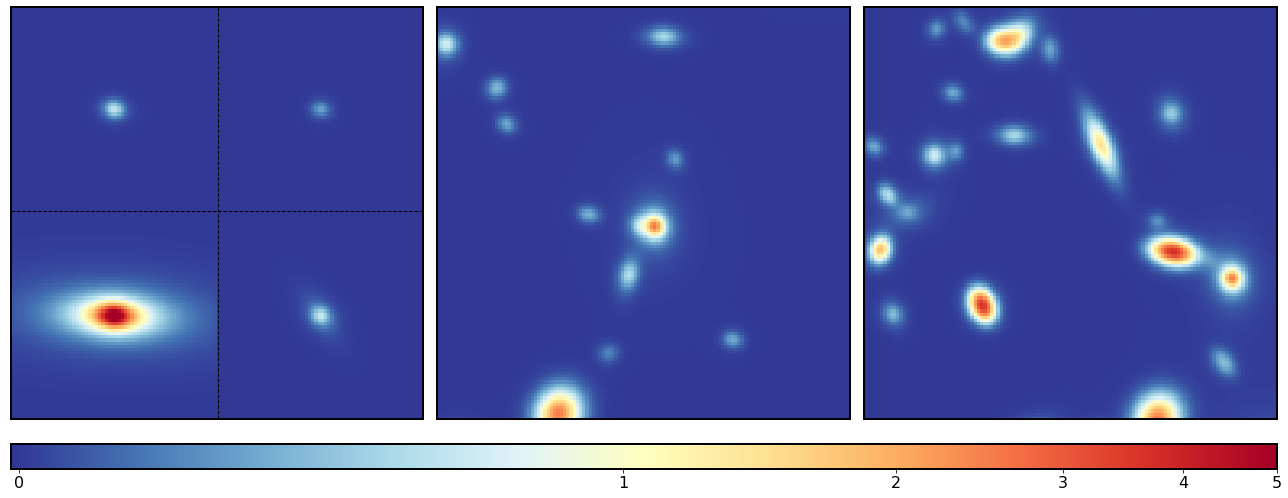

In [11]:
plt.close()

fig=plt.figure(figsize=(18,7))
grid = ImageGrid(fig, 111,     
                 nrows_ncols=(1,3),
                 axes_pad=0.2,
                 share_all=True,
                 cbar_location="bottom",
                 cbar_mode="single",
                 cbar_size="2%",
                 cbar_pad=0.15,
                 )

ax=grid[0]
im=ax.imshow(b,origin='lower',aspect='equal',cmap='RdYlBu_r',interpolation='None',\
             norm=simple_norm(a,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=5.))
ax.axvline(64,c='black',linewidth=1,ls='--')
ax.axhline(64,c='black',linewidth=1,ls='--')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax=grid[1]
im=ax.imshow(a,origin='lower',aspect='equal',cmap='RdYlBu_r',interpolation='None',\
             norm=simple_norm(a,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=5.))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax=grid[2]
im=ax.imshow(g,origin='lower',aspect='equal',cmap='RdYlBu_r',interpolation='None',\
             norm=simple_norm(g,'asinh',asinh_a=0.1,min_cut=-0.01,max_cut=5.))

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])


ax.cax.colorbar(im)

plt.tight_layout()
gc.collect()
fig.savefig('simulation_isoblend.pdf')

5

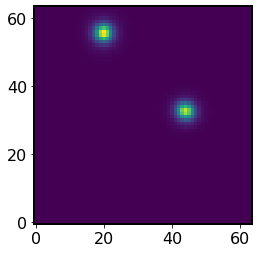

In [7]:
outDir='../../../../sim/galaxy_cosmoR_psf60'
a=fpfs.simutil.make_cosmo_sim(outDir,'g1-0000',Id0=35,ny=64,nx=64,do_write=False,return_array=True)
plt.close()
plt.imshow(a,origin='lower')
gc.collect()

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=0, xmax=63, ymin=0, ymax=63), moments_status=0, observed_shape=galsim.Shear((0.02137119521618136-0.029002692125567928j)), moments_sigma=1.8481427431106567, moments_amp=5.164806842803955, moments_centroid=galsim.PositionD(x=36.21484328918498, y=30.7757551338958), moments_rho4=2.1388892128898243, moments_n_iter=36, correction_status=-10)


10

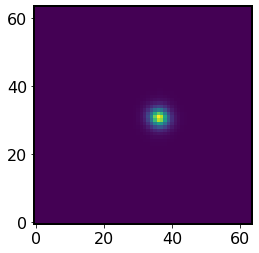

In [141]:
outDir='../../../../sim/galaxy_cosmoR_psf60'
a=make_cosmo_sim(outDir,'g1-0000',Id0=35,ny=64,nx=64,do_write=False,return_array=True)
plt.close()
plt.imshow(a,origin='lower')
gc.collect()

In [11]:
def make_cosmo_sim(outDir,gname,Id0,ny,nx,do_write=True,return_array=False):
    """Makes cosmo galaxy image simulation (blended)
    Args:
        outDir (str):
            output directory
        gname (str):
            shear distortion setup
        Id0 (int):
            index of the simulation
        ny (int):
            number of galaxies in y direction
        nx (int):
            number of galaxies in x direction
        do_write (bool):
            whether write output [default: True]
        return_array (bool):
            whether return galaxy array [default: False]
    """
    eta     =   5
    irot    =   (Id0//8)%(2**eta)
    cgid    =   int(Id0%8)
    np.random.seed(cgid)
    outFname=   os.path.join(outDir,'image-%d-%s.fits' %(Id0,gname))
    if os.path.isfile(outFname):
        logging.info('Already have the outcome.')
        if do_write:
            logging.info('Nothing to write.')
        if return_array:
            return fitsio.read(outFname)
        else:
            return None

    rotArray    =   fpfs.simutil.make_ringrot_radians(eta)
    # 2**7*8=1024 galaxy ID
    # 2**7 different rotations and dilations
    # for each galaxy ID 10000 parametric galaxies
    logging.info('We have %d rotation realizations' %len(rotArray))
    ang     =   rotArray[irot]*galsim.radians
    ud      =   galsim.UniformDeviate(Id0+212)
    rescale =   1.+(ud()-0.5)*0.1
    # Galsim galaxies
    directory   =   os.path.join(os.environ['homeWrk'],'COSMOS/galsim_train/COSMOS_25.2_training_sample/')
    catName     =   'real_galaxy_catalog_25.2.fits'
    cosmos_cat  =   galsim.COSMOSCatalog(catName,dir=directory)

    # Basic parameters
    bigfft      =   galsim.GSParams(maximum_fft_size=10240)
    # Get the shear information
    # Three choice on g(-0.02,0,0.02)
    gList   =   np.array([-0.02,0.,0.02])
    gList   =   gList[[eval(i) for i in gname.split('-')[-1]]]

    # PSF
    pix_scale=  0.168 #[arcsec]
    if 'HSC' in outDir:
        psfFname=   os.path.join(outDir,'psf-HSC.fits')
        assert os.path.isfile(psfFname), 'Cannot find input HSC PSF files'
        psfImg  =   galsim.fits.read(psfFname)
        psfInt  =   galsim.InterpolatedImage(psfImg,scale=pix_scale,flux = 1.)
        logging.info('Using HSC PSF')
    else:
        psfFWHM =   eval(outDir.split('_psf')[-1])/100.
        psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
        psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
        logging.info('Using Moffat PSF with FWHM: %s arcsec'%psfFWHM)

    # catalog
    density =   1 #[/arcmin^2]
    ngal    =   max(int(nx*ny*0.93**2.*pix_scale/3600.*density),1)
    logging.info('We have %d galaxies in total' %ngal)
    cosmo252=   fpfs.simutil.cosmoHSTGal('252')
    cosmo252.readHSTsample()
    ntrain  =   len(cosmo252.catused)
    inds    =   np.random.randint(0,ntrain,ngal)
    inCat   =   cosmo252.catused[inds]

    xarray  =   nx*0.92*np.random.rand(ngal)+nx*0.04
    yarray  =   ny*0.92*np.random.rand(ngal)+ny*0.04
    if True:
        xarray  =   np.array([32.])
        yarray  =   np.array([32.])


    #zbound  =   np.array([0.,0.561,0.906,1.374,5.410]) #before sim3
    #zbound  =   np.array([0.005,0.5477,0.8874,1.3119,3.0]) #sim 3
    zbound  =   np.array([0.0001,0.5477,0.8874,1.3119,12.0]) #sim 3
    gal_image   =   galsim.ImageF(nx,ny,scale=pix_scale)
    gal_image.setOrigin(0,0)

    for ii in range(ngal):
        ss  =   inCat[ii]
        gInd=   np.where((ss['zphot']>zbound[:-1])&(ss['zphot']<=zbound[1:]))[0]
        if len(gInd)==1:
            if gname.split('-')[0]=='g1':
                g1=gList[gInd][0]
                g2=0.
            elif gname.split('-')[0]=='g2':
                g1=0.
                g2=gList[gInd][0]
            else:
                raise ValueError('g1 or g2 must be in gname')
        else:
            g1  =   0.; g2  = 0.
        # each galaxy
        gal =   cosmos_cat.makeGalaxy(gal_type='parametric',index=ss['index'],gsparams=bigfft)
        flux=   10**((27.-ss['mag_auto'])/2.5)
        gal =   gal.withFlux(flux)
        return ss

        # rescale the radius while keeping the surface brightness the same
        gal =   gal.expand(rescale)
        # rotate by 'ang'
        gal =   gal.rotate(ang)
        # lensing shear
        gal =   gal.shift(4.3*pix_scale,-1.2*pix_scale)
        gal =   gal.shear(g1=g1,g2=g2)

        xi  =   xarray[ii]
        yi  =   yarray[ii]
        xu  =   int(xi)
        yu  =   int(yi)
        dx  =   (0.5+xi-xu)*pix_scale
        dy  =   (0.5+yi-yu)*pix_scale
        gal =   gal.shift(dx,dy)
        # PSF
        gal =   galsim.Convolve([psfInt,gal],gsparams=bigfft)
        gPix=   gal.getGoodImageSize(pix_scale)
        rx1 =   np.min([gPix//1.0,xi])
        rx2 =   np.min([gPix//1.0,nx-xu-1])
        rx  =   int(min(rx1,rx2))
        del rx1,rx2
        ry1 =   np.min([gPix//1.0,yi])
        ry2 =   np.min([gPix//1.0,ny-yu-1])
        ry  =   int(min(ry1,ry2))
        del ry1,ry2
        # draw galaxy
        b   =   galsim.BoundsI(xu-rx,xu+rx-1,yu-ry,yu+ry-1)
        try:
            sub_img =   gal_image[b]
        except:
            print(yu,ry,xi)
            print(xu-rx,xu+rx-1,yu-ry,yu+ry-1)
            return
        del xu,yu
        gal.drawImage(sub_img,add_to_image=True)
        del gal,b,sub_img
        gc.collect()
    print(galsim.hsm.FindAdaptiveMom(gal_image))
    del inCat,cosmos_cat,psfInt
    if do_write:
        gal_image.write(outFname,clobber=True)
    if return_array:
        return gal_image.array


In [12]:
outDir='galaxy_cosmo085_psf60'
a=make_cosmo_sim(outDir,'g1-0000',Id0=35,ny=64,nx=64,do_write=False,return_array=True)

In [13]:
a.dtype.names

('IDENT',
 'mag_auto',
 'flux_radius',
 'zphot',
 'sersicfit',
 'bulgefit',
 'fit_status',
 'fit_mad_s',
 'fit_mad_b',
 'fit_dvc_btt',
 'use_bulgefit',
 'viable_sersic',
 'hlr',
 'flux',
 'ra',
 'dec',
 'index')

In [16]:
a['fit_mad_b']

0.0018943776568743492